In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [4]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv', header=False, index=False)

train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv",30)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv",30)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv",30)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 30: 0
torch.Size([142397, 30]) torch.Size([142397])
length > 30: 0
torch.Size([35600, 30]) torch.Size([35600])
length > 30: 0
torch.Size([44499, 30]) torch.Size([44499])


# 2. train

In [7]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    


In [8]:
device = torch.device("cuda",0)

In [9]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 159.61594, loss1: 1.71799, loss2_3: 157.89795
	train_acc: 0.7756, test_acc: 0.7767696629213483, time: 45.33
best_acc: 0.7767696629213483
epoch: 2, loss: 107.92861, loss1: 0.88568, loss2_3: 107.04293
	train_acc: 0.8166, test_acc: 0.8153089887640449, time: 65.78
best_acc: 0.8153089887640449
epoch: 3, loss: 100.87598, loss1: 0.83497, loss2_3: 100.04101
	train_acc: 0.8308, test_acc: 0.8301685393258427, time: 89.49
best_acc: 0.8301685393258427
epoch: 4, loss: 97.84169, loss1: 0.81168, loss2_3: 97.03000
	train_acc: 0.8419, test_acc: 0.8426123595505618, time: 89.31
best_acc: 0.8426123595505618
epoch: 5, loss: 95.25465, loss1: 0.78985, loss2_3: 94.46480
	train_acc: 0.8393, test_acc: 0.838061797752809, time: 63.73
epoch: 6, loss: 93.31366, loss1: 0.77655, loss2_3: 92.53711
	train_acc: 0.8308, test_acc: 0.8311516853932585, time: 64.26
epoch: 7, loss: 91.61994, loss1: 0.75463, loss2_3: 90.86531
	train_acc: 0.8476, test_acc: 0.8472471910112359, time: 62.33
best_acc: 0.8472471910112

epoch: 58, loss: 78.27410, loss1: 0.62901, loss2_3: 77.64509
	train_acc: 0.8741, test_acc: 0.8705898876404494, time: 85.99
epoch: 59, loss: 78.21847, loss1: 0.62532, loss2_3: 77.59315
	train_acc: 0.8722, test_acc: 0.8660955056179775, time: 87.59
epoch: 60, loss: 78.19763, loss1: 0.62728, loss2_3: 77.57035
	train_acc: 0.8739, test_acc: 0.8700561797752809, time: 87.12
epoch: 61, loss: 77.94862, loss1: 0.62177, loss2_3: 77.32685
	train_acc: 0.8749, test_acc: 0.8715168539325843, time: 87.22
best_acc: 0.8715168539325843
epoch: 62, loss: 77.93366, loss1: 0.62381, loss2_3: 77.30984
	train_acc: 0.8744, test_acc: 0.871685393258427, time: 87.15
best_acc: 0.871685393258427
epoch: 63, loss: 77.71453, loss1: 0.62602, loss2_3: 77.08852
	train_acc: 0.8736, test_acc: 0.8717134831460674, time: 85.98
best_acc: 0.8717134831460674
epoch: 64, loss: 77.69325, loss1: 0.62081, loss2_3: 77.07244
	train_acc: 0.8754, test_acc: 0.8713483146067416, time: 86.93
epoch: 65, loss: 77.69057, loss1: 0.62001, loss2_3: 77

epoch: 119, loss: 75.10066, loss1: 0.60143, loss2_3: 74.49923
	train_acc: 0.8807, test_acc: 0.8723876404494382, time: 77.22
epoch: 120, loss: 75.00407, loss1: 0.60148, loss2_3: 74.40259
	train_acc: 0.8807, test_acc: 0.8737640449438202, time: 77.23
best_acc: 0.8737640449438202
epoch: 121, loss: 74.82857, loss1: 0.60055, loss2_3: 74.22802
	train_acc: 0.8794, test_acc: 0.8705337078651686, time: 77.36
epoch: 122, loss: 75.14674, loss1: 0.59943, loss2_3: 74.54732
	train_acc: 0.8803, test_acc: 0.8729494382022472, time: 77.72
epoch: 123, loss: 74.88347, loss1: 0.59922, loss2_3: 74.28425
	train_acc: 0.8778, test_acc: 0.8705898876404494, time: 77.64
epoch: 124, loss: 74.99961, loss1: 0.60229, loss2_3: 74.39731
	train_acc: 0.8810, test_acc: 0.8707584269662921, time: 76.98
epoch: 125, loss: 74.91091, loss1: 0.60010, loss2_3: 74.31081
	train_acc: 0.8817, test_acc: 0.8727808988764045, time: 77.54
epoch: 126, loss: 74.77777, loss1: 0.59876, loss2_3: 74.17901
	train_acc: 0.8818, test_acc: 0.871573033

epoch: 181, loss: 72.96398, loss1: 0.58693, loss2_3: 72.37704
	train_acc: 0.8863, test_acc: 0.8719943820224719, time: 77.21
epoch: 182, loss: 72.72593, loss1: 0.58520, loss2_3: 72.14073
	train_acc: 0.8871, test_acc: 0.8728651685393258, time: 77.68
epoch: 183, loss: 72.69709, loss1: 0.58592, loss2_3: 72.11117
	train_acc: 0.8870, test_acc: 0.8722471910112359, time: 77.38
epoch: 184, loss: 72.79838, loss1: 0.58652, loss2_3: 72.21186
	train_acc: 0.8870, test_acc: 0.8717977528089887, time: 77.11
epoch: 185, loss: 72.79235, loss1: 0.58444, loss2_3: 72.20791
	train_acc: 0.8852, test_acc: 0.8699157303370787, time: 78.08
epoch: 186, loss: 72.64318, loss1: 0.58375, loss2_3: 72.05943
	train_acc: 0.8857, test_acc: 0.8706741573033708, time: 76.77
epoch: 187, loss: 72.75671, loss1: 0.58773, loss2_3: 72.16898
	train_acc: 0.8856, test_acc: 0.8703651685393259, time: 77.65
epoch: 188, loss: 72.46326, loss1: 0.58404, loss2_3: 71.87922
	train_acc: 0.8866, test_acc: 0.870561797752809, time: 77.60
epoch: 18

epoch: 243, loss: 70.12056, loss1: 0.57140, loss2_3: 69.54916
	train_acc: 0.8921, test_acc: 0.8704775280898877, time: 79.63
epoch: 244, loss: 70.04170, loss1: 0.57363, loss2_3: 69.46807
	train_acc: 0.8924, test_acc: 0.8712359550561798, time: 77.12
epoch: 245, loss: 70.42904, loss1: 0.57237, loss2_3: 69.85667
	train_acc: 0.8922, test_acc: 0.8711797752808988, time: 80.31
epoch: 246, loss: 70.24167, loss1: 0.56843, loss2_3: 69.67324
	train_acc: 0.8924, test_acc: 0.8704775280898877, time: 77.25
epoch: 247, loss: 70.03180, loss1: 0.57369, loss2_3: 69.45811
	train_acc: 0.8937, test_acc: 0.8709831460674158, time: 80.86
epoch: 248, loss: 70.24867, loss1: 0.57074, loss2_3: 69.67793
	train_acc: 0.8937, test_acc: 0.8722471910112359, time: 79.91
epoch: 249, loss: 69.87408, loss1: 0.56721, loss2_3: 69.30687
	train_acc: 0.8927, test_acc: 0.8679775280898876, time: 78.58
epoch: 250, loss: 70.10058, loss1: 0.56949, loss2_3: 69.53109
	train_acc: 0.8937, test_acc: 0.8701685393258427, time: 79.83


# 3. test

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [11]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [12]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [13]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.8685813164340772
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     22330
           1       0.85      0.89      0.87     22169

    accuracy                           0.87     44499
   macro avg       0.87      0.87      0.87     44499
weighted avg       0.87      0.87      0.87     44499



rf auc : 0.9394461048586644


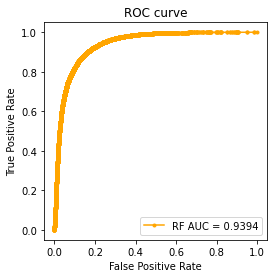

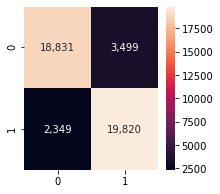

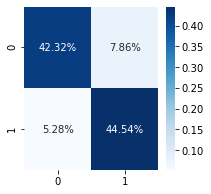

In [14]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()